# Inversion of a sphere based on gravity response
# ( Transfered to TensorFlow 2.0)

This is a simple example for the probabilistic inversion of a classical geophysical example: the inversion of a sphere in the subsurface with a different density to the environment based on observed gravity data.

We start with the simplest possible case of only one observation (directly above the sphere) and only depth as an uncertain variable and then make the model progressively more complex.

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

import seaborn as sns
import pandas as pd
%matplotlib inline

np.random.seed(111)
# tf.set_random_seed(111)


We now calculate the effect of this density contrast that would be observed on the surface. This is a well-studied example with an analytical solution:

$$g(x) = 10^5 \;\frac{4}{3} \,\pi \;\frac{r^3 \,\Delta \rho\, G\, z}
{\sqrt{\left( x^2 + z^2\right)^3}}$$

where:

- $z$ is the vertical position of the center of the sphere (lateral position at origin),
- $r$ its radius,
- $\Delta \rho$ the density difference to the surrounding domain,
- $G$ the gravitational constant,
- and $x$ the position at which the gravitational acceleration is calculated.


In [2]:
def grav_analytical(x, sphere_center, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'sphere_center' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5


## Geometric model

We consider here a sphere in the subsurface with a different density. 

spherical point mass

In [3]:
#True model

sphere_center_true = 300. #m 
density_difference_true = 500. # kg/m^3: density diffrence to surrounding domain
sphere_radius_true = 100. #m

truevalue_list = [sphere_center_true,density_difference_true,sphere_radius_true]
x_domain=np.linspace(-1000,1000,101) #m

In [4]:
x_obs = np.linspace(-250., 250., 11)
grav_all = grav_analytical(x_domain, sphere_center_true, sphere_radius_true, density_difference_true)
grav_obs_array = grav_analytical(x_obs, sphere_center_true, sphere_radius_true, density_difference_true)
noise = norm(0,0.01).rvs(len(grav_obs_array))
grav_obs_array_withnoise = grav_obs_array +noise

/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


In [5]:
grav_obs_array_withnoise

array([0.05903379, 0.09325413, 0.12603046, 0.12897358, 0.1410927 ,
       0.15062356, 0.14837635, 0.12898567, 0.10370969, 0.07757154,
       0.07276111])

Calculate the variance of the noise, put the variance in an noise tensor

In [6]:
noise_variance = np.std(noise)**2

noise_1 = tf.convert_to_tensor([noise_variance],dtype = tf.float32)
eye = tf.eye(x_obs.shape[0])
noise_tensor = tf.multiply(noise_1,eye)

Text(0, 0.5, 'Y [m]')

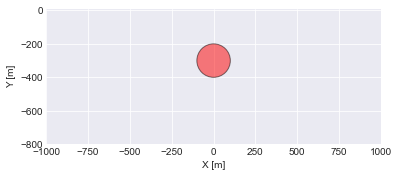

In [7]:
plt.style.use('seaborn-darkgrid')
ax = plt.subplot(aspect='equal') 

# create circle object as matplotlib patch
circle1 = plt.Circle((0, -sphere_center_true), sphere_radius_true, 
                     facecolor='r', edgecolor='k', alpha=0.5)

ax.add_artist(circle1)

# set model domain
ax.set_xlim([-1000,1000])
ax.set_ylim([-800,10])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")


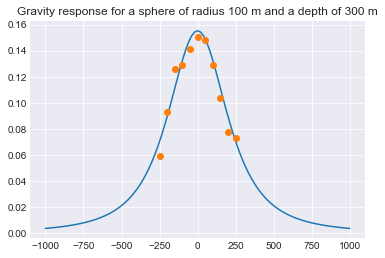

In [8]:
plt.plot(x_domain, grav_all)
plt.plot(x_obs, grav_obs_array_withnoise, 'o', label="data")
plt.title("Gravity response for a sphere of radius 100 m and a depth of 300 m");

### Algorithm Flowing hIPPYlib MCMC http://g2s3.com/labs/notebooks/SubsurfaceBayesian.html

Bayes’s Theorem

\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \pi_{\mathrm{like}}\left(\mathbf{d}_{\mathrm{obs}} | \mathrm{m}\right) \mathrm{d} \mu_{\mathrm{prior}}(\mathrm{m})
\end{equation}

Define the Prior
\begin{equation}
\mu_{\text {prior }} \sim \mathcal{N}\left(m_{\text {prior }}, C_{\text {prior }}\right)
\end{equation}

In [9]:
# sphere_center, density_difference, sphere_radius

mu_prior = [280., 480., 80.]


cov = [[ 100,  0.,  0.],
        [ 0.,  100, 0.],
        [ 0., 0.,  100]]


In [10]:
xvals =[]
norm_list =[]

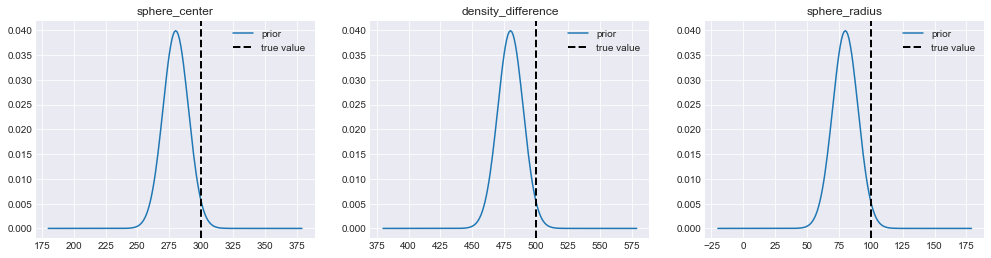

In [11]:
for i in range(3):
    xvals.append(np.arange(mu_prior[i]-100,mu_prior[i]+100))
    norm_list.append(norm.pdf(xvals[i],mu_prior[i],np.sqrt(cov[i][i])))
    
np.shape(xvals)

name_list = ["sphere_center", "density_difference", "sphere_radius"]

fig, axes = plt.subplots(1, 3, sharex='col', sharey='col')
fig.set_size_inches(17, 4)


for i in range(3):
    
    axes[i].plot(xvals[i], norm_list[i],label="prior")
    axes[i].title.set_text(name_list[i])
    axes[i].axvline(truevalue_list[i], label="true value", color='k', 
            linestyle='--', linewidth=2)
    axes[i].legend();

    

Define the Likelihood
\begin{equation}
\mathbf{d}_{\mathrm{obs}}=\mathbf{f}(\mathrm{m})+\mathbf{e}, \quad \mathbf{e} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{\Gamma}_{\mathrm{noise}}\right)
\end{equation}
\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

In [12]:
mu_prior = tf.convert_to_tensor(mu_prior)
cov = tf.convert_to_tensor(cov)


In [13]:
# Defind f(m). Here f is the parameter-to-observable map that takes a 
# parameter m and maps it to the space observation vector dobs.
@tf.function
def grav_analytical_tf(x, mu, cov,sess):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G 
               * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 

    return gravity



### Gradient decent to find MAP 

In [ ]:
## function compute G^T C^-1 G

@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float32)
    matrix2 = tf.cast(matrix2,tf.float32)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

#### The posterior


\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}

#### negative log of the posterior
\begin{equation}
\left(\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}


term 1 = 
\begin{equation}
\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}
\end{equation}

term 2 =
\begin{equation}
\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}
\end{equation}


In [17]:
#     print(sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)))

## initial guess
mu = tf.Variable([200., 400., 50.])

In [18]:
@tf.function
def grav_analytical_tf_det(x, mu, cov):
    # [sphere_center, density_difference, sphere_radius]

    
    G=tf.constant(6.67e-11,dtype = tf.float32)
    sphere_center = mu[0]
    density_difference = mu[1]
    sphere_radius = mu[2]
    
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G 
               * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 

    return gravity

In [19]:
grav_obs_array_withnoise = tf.convert_to_tensor(grav_obs_array_withnoise,dtype=tf.float32)
x_obs = tf.convert_to_tensor(x_obs,dtype=tf.float32)

In [20]:
cost = []

def loss(mu):
    grav = grav_analytical_tf_det(x_obs,mu, cov)
    term_1 = matrixcompute(grav,grav_obs_array_withnoise,noise_tensor)
    term_2 = matrixcompute(mu,mu_prior,cov)
    return tf.add(term_1,term_2)


def loss_minimize():
    grav = grav_analytical_tf_det(x_obs,mu, cov)
    term_1 = matrixcompute(grav,grav_obs_array_withnoise,noise_tensor)
    term_2 = matrixcompute(mu,mu_prior,cov)
    return tf.add(term_1,term_2)

opt = tf.keras.optimizers.SGD(learning_rate=0.1)

step = 5000

for i in range(step):
    
    opt.minimize(loss_minimize, var_list=mu)
    print (loss(mu).numpy(), mu.numpy())
    cost.append(loss(mu).numpy())

    
MAP = mu

[[895.53094]] [199.77829  400.1845    52.538498]
[[820.0576]] [199.52261 400.38092  55.23003]
[[736.90784]] [199.23236  400.58957   58.060658]
[[647.52936]] [198.90913  400.81012   61.003853]
[[554.5952]] [198.55779 401.04123  64.01716]
[[462.08276]] [198.18747 401.28018  67.03993]
[[374.9473]] [197.81229 401.52267  69.99399]
[[298.2545]] [197.45091 401.76297  72.78905]
[[235.90857]] [197.12459 401.99448  75.33415]
[[189.50908]] [196.85344 402.21085  77.55362]
[[158.01324]] [196.6522  402.40732  79.40244]
[[138.4465]] [196.52716 402.5817   80.87449]
[[127.18802]] [196.47565 402.7345   81.99947]
[[121.05805]] [196.48836 402.86832  82.83071]
[[117.793686]] [196.55278  402.98672   83.430084]
[[116.01042]] [196.65628 403.09338  83.85621]
[[114.94975]] [196.78792  403.1915    84.158104]
[[114.227875]] [196.93907 403.28357  84.37351]
[[113.66106]] [197.1034  403.3715   84.52992]
[[113.16457]] [197.27638 403.45657  84.64664]
[[112.700424]] [197.45496 403.53976  84.73687]
[[112.251755]] [197.6

[[63.031967]] [223.0756  415.9747   89.77732]
[[62.8443]] [223.19373 416.04095  89.79843]
[[62.657417]] [223.31155  416.10715   89.819466]
[[62.471382]] [223.4291  416.17325  89.84044]
[[62.286133]] [223.54634 416.2393   89.86134]
[[62.10164]] [223.6633  416.30527  89.88218]
[[61.917984]] [223.77997 416.37115  89.90295]
[[61.735123]] [223.89635 416.43698  89.92365]
[[61.553017]] [224.01245 416.50275  89.94429]
[[61.37168]] [224.12827 416.56845  89.96486]
[[61.191154]] [224.24379 416.63406  89.98537]
[[61.01136]] [224.35904  416.69962   90.005806]
[[60.832344]] [224.474    416.7651    90.026184]
[[60.654083]] [224.58868 416.83054  90.0465 ]
[[60.476593]] [224.7031  416.89587  90.06675]
[[60.29985]] [224.81721 416.96115  90.08693]
[[60.12385]] [224.93106 417.02637  90.10705]
[[59.948574]] [225.04463  417.09152   90.127106]
[[59.77407]] [225.15793 417.1566   90.1471 ]
[[59.600285]] [225.27095 417.2216   90.16703]
[[59.42723]] [225.3837  417.28653  90.1869 ]
[[59.25491]] [225.49617 417.351

[[37.27653]] [241.89792 427.8892   92.9384 ]
[[37.189568]] [241.97314 427.94308  92.95018]
[[37.10293]] [242.04822 427.99692  92.96193]
[[37.016556]] [242.12314 428.05072  92.97365]
[[36.93051]] [242.19789 428.10446  92.98534]
[[36.844757]] [242.27249  428.15814   92.996994]
[[36.759308]] [242.34694 428.21176  93.00862]
[[36.67414]] [242.42123 428.26532  93.02022]
[[36.589283]] [242.49536  428.31885   93.031784]
[[36.50473]] [242.56934 428.3723   93.04331]
[[36.420456]] [242.64316 428.42572  93.05481]
[[36.33647]] [242.71683  428.47906   93.066284]
[[36.2528]] [242.79034 428.53235  93.07772]
[[36.169376]] [242.86371 428.5856   93.08913]
[[36.086258]] [242.93692 428.6388   93.1005 ]
[[36.003445]] [243.00998 428.69193  93.11185]
[[35.92092]] [243.08289 428.745    93.12317]
[[35.83868]] [243.15564 428.798    93.13445]
[[35.7567]] [243.22824  428.85098   93.145706]
[[35.67502]] [243.30069 428.9039   93.15693]
[[35.59362]] [243.373   428.95676  93.16813]
[[35.51249]] [243.44516 429.00955  9

[[24.70763]] [254.13109 437.51     94.755  ]
[[24.661888]] [254.18193 437.55408  94.7621 ]
[[24.616299]] [254.23267 437.5981   94.76919]
[[24.570835]] [254.28331 437.6421   94.77625]
[[24.52552]] [254.33386 437.68604  94.7833 ]
[[24.48035]] [254.38431 437.72992  94.79034]
[[24.435307]] [254.43466  437.77377   94.797356]
[[24.390406]] [254.48492 437.81757  94.80435]
[[24.345633]] [254.5351  437.86133  94.81133]
[[24.301006]] [254.58517 437.90503  94.8183 ]
[[24.25652]] [254.63515 437.9487   94.82525]
[[24.212166]] [254.68503 437.9923   94.83218]
[[24.167938]] [254.73482 438.0359   94.83909]
[[24.123856]] [254.78452  438.0794    94.845985]
[[24.079899]] [254.83412 438.1229   94.85287]
[[24.036068]] [254.88364 438.16635  94.85973]
[[23.99239]] [254.93304 438.20975  94.86658]
[[23.948822]] [254.98236  438.2531    94.873405]
[[23.905407]] [255.03159 438.29642  94.88022]
[[23.862114]] [255.08072 438.3397   94.88702]
[[23.818954]] [255.12976 438.3829   94.89379]
[[23.77592]] [255.17871 438.42

[[17.798328]] [262.63354 445.48938  95.88301]
[[17.77281]] [262.66876 445.52536  95.88741]
[[17.74737]] [262.70392 445.56128  95.8918 ]
[[17.721987]] [262.739   445.59717  95.89618]
[[17.696676]] [262.77405 445.63303  95.90055]
[[17.671444]] [262.80902 445.66885  95.90491]
[[17.646263]] [262.84393  445.70465   95.909256]
[[17.62117]] [262.87878 445.7404   95.91359]
[[17.59615]] [262.91357  445.7761    95.917915]
[[17.571186]] [262.9483  445.81177  95.92223]
[[17.546295]] [262.98297  445.8474    95.926544]
[[17.521473]] [263.01758 445.88303  95.93084]
[[17.496725]] [263.05212 445.91858  95.93513]
[[17.472042]] [263.0866  445.9541   95.93941]
[[17.44743]] [263.12103 445.9896   95.94367]
[[17.422876]] [263.1554  446.02505  95.94793]
[[17.398394]] [263.1897  446.0605   95.95218]
[[17.373985]] [263.22394 446.0959   95.95642]
[[17.349644]] [263.25812 446.13123  95.96065]
[[17.325375]] [263.29224 446.16653  95.96487]
[[17.301165]] [263.3263  446.2018   95.96908]
[[17.27702]] [263.3603   446.2

[[13.933683]] [268.4581   451.8566    96.573814]
[[13.918604]] [268.48322  451.8861    96.576614]
[[13.903557]] [268.50827 451.9156   96.57941]
[[13.888553]] [268.5333  451.94504  96.58219]
[[13.873581]] [268.55826 451.9745   96.58498]
[[13.85865]] [268.5832  452.0039   96.58775]
[[13.843749]] [268.6081  452.0333   96.59052]
[[13.8288965]] [268.63293  452.06265   96.593285]
[[13.814083]] [268.65775 452.09198  96.59604]
[[13.799307]] [268.6825   452.12128   96.598785]
[[13.784559]] [268.7072  452.15054  96.60153]
[[13.769865]] [268.7319  452.17978  96.60427]
[[13.755205]] [268.75653 452.20898  96.607  ]
[[13.740578]] [268.78113  452.23816   96.609726]
[[13.725994]] [268.8057  452.2673   96.61244]
[[13.711447]] [268.8302  452.29642  96.61515]
[[13.696938]] [268.85468 452.3255   96.61786]
[[13.682474]] [268.8791  452.35455  96.62056]
[[13.668039]] [268.90347 452.38358  96.62325]
[[13.653641]] [268.92783 452.41257  96.62594]
[[13.639287]] [268.95212 452.44153  96.62862]
[[13.624966]] [268.

[[11.598656]] [272.66922 457.1332   97.01763]
[[11.589525]] [272.68726 457.1574   97.01941]
[[11.580409]] [272.70526 457.18158  97.02118]
[[11.571323]] [272.72324 457.20572  97.02295]
[[11.562261]] [272.74118 457.22983  97.02471]
[[11.553214]] [272.7591   457.25394   97.026474]
[[11.544193]] [272.77698 457.278    97.02823]
[[11.535198]] [272.79483  457.30206   97.029976]
[[11.526223]] [272.81265 457.32608  97.03172]
[[11.517273]] [272.83044 457.35007  97.03346]
[[11.508341]] [272.8482  457.37405  97.0352 ]
[[11.499431]] [272.86594  457.398     97.036934]
[[11.490549]] [272.88364  457.42194   97.038666]
[[11.481684]] [272.90134 457.44583  97.04039]
[[11.47283]] [272.919    457.46973   97.042114]
[[11.464003]] [272.93665 457.4936   97.04383]
[[11.455202]] [272.95425 457.51743  97.04555]
[[11.446421]] [272.97183 457.54123  97.04726]
[[11.43766]] [272.98938  457.565     97.048965]
[[11.428926]] [273.0069  457.58878  97.05067]
[[11.42021]] [273.02438 457.61252  97.05237]
[[11.411518]] [273.

[[10.187037]] [275.6686  461.3987   97.29453]
[[10.181347]] [275.68173  461.4186    97.295654]
[[10.175665]] [275.69485 461.43848  97.29677]
[[10.170004]] [275.70795 461.45834  97.29788]
[[10.164351]] [275.721    461.47818   97.298996]
[[10.158718]] [275.73407 461.498    97.30011]
[[10.153084]] [275.7471   461.5178    97.301216]
[[10.147476]] [275.7601  461.53757  97.30232]
[[10.141879]] [275.7731  461.5573   97.30342]
[[10.136296]] [275.78607 461.57706  97.30452]
[[10.130721]] [275.799   461.59677  97.30562]
[[10.125166]] [275.81192 461.61646  97.30672]
[[10.11962]] [275.82483 461.63614  97.30781]
[[10.114087]] [275.8377 461.6558  97.3089]
[[10.108572]] [275.85056 461.6754   97.30998]
[[10.103063]] [275.8634   461.69504   97.311066]
[[10.097576]] [275.87622 461.71463  97.31215]
[[10.092095]] [275.889    461.73422   97.313225]
[[10.086631]] [275.9018  461.75378  97.3143 ]
[[10.081177]] [275.91455 461.77332  97.31538]
[[10.075734]] [275.92728  461.79285   97.316444]
[[10.070303]] [275.9

[[9.296965]] [277.86807 464.92273  97.46832]
[[9.293367]] [277.8777  464.9391   97.46901]
[[9.289782]] [277.88727  464.9554    97.469696]
[[9.2862]] [277.89685 464.97174  97.47038]
[[9.282627]] [277.9064  464.98804  97.47107]
[[9.279061]] [277.91595  465.0043    97.471756]
[[9.275513]] [277.92548  465.02057   97.472435]
[[9.271963]] [277.935    465.0368    97.473114]
[[9.268426]] [277.9445  465.05304  97.47379]
[[9.264895]] [277.95398 465.06924  97.47447]
[[9.261372]] [277.96344 465.08545  97.47514]
[[9.257864]] [277.9729   465.10162   97.475815]
[[9.254353]] [277.98233 465.1178   97.47649]
[[9.250853]] [277.99176 465.13394  97.47716]
[[9.247366]] [278.00116 465.1501   97.47783]
[[9.243887]] [278.01056 465.1662   97.47849]
[[9.240406]] [278.01993 465.1823   97.47916]
[[9.2369375]] [278.0293  465.1984   97.47982]
[[9.233481]] [278.03864 465.21448  97.48048]
[[9.230032]] [278.04797 465.23053  97.48113]
[[9.226595]] [278.05728 465.24655  97.48179]
[[9.223158]] [278.0666   465.26257   97.4

[[8.728949]] [279.4861  467.83163  97.57354]
[[8.726652]] [279.49313  467.84506   97.573944]
[[8.724365]] [279.50015 467.85846  97.57435]
[[8.7220745]] [279.50717  467.87186   97.574745]
[[8.719798]] [279.51416 467.88522  97.57514]
[[8.7175255]] [279.52115 467.8986   97.57554]
[[8.715258]] [279.52814  467.91193   97.575935]
[[8.712994]] [279.5351  467.92526  97.57633]
[[8.710731]] [279.54205 467.9386   97.57673]
[[8.708479]] [279.549    467.9519    97.577126]
[[8.706225]] [279.55594 467.9652   97.57752]
[[8.7039795]] [279.56287 467.9785   97.57791]
[[8.701742]] [279.5698  467.99176  97.5783 ]
[[8.699508]] [279.5767  468.005    97.57869]
[[8.697279]] [279.5836  468.01825  97.57908]
[[8.695055]] [279.59045 468.0315   97.57947]
[[8.692833]] [279.59732 468.0447   97.57985]
[[8.690621]] [279.6042  468.05792  97.58024]
[[8.688414]] [279.61102 468.0711   97.58062]
[[8.686207]] [279.61786 468.0843   97.581  ]
[[8.684011]] [279.6247  468.09744  97.58138]
[[8.681814]] [279.6315   468.1106    97.

[[8.369069]] [280.65775 470.18646  97.63233]
[[8.3675785]] [280.66293 470.1975   97.63255]
[[8.366088]] [280.66812  470.20856   97.632774]
[[8.364608]] [280.6733  470.21957  97.63299]
[[8.363123]] [280.67847 470.2306   97.6332 ]
[[8.361649]] [280.68362  470.2416    97.633415]
[[8.360176]] [280.68878 470.2526   97.63363]
[[8.358702]] [280.69394 470.26358  97.63384]
[[8.357233]] [280.69907  470.27457   97.634056]
[[8.355771]] [280.7042  470.28552  97.63427]
[[8.354312]] [280.70932 470.29648  97.63448]
[[8.352856]] [280.71445 470.3074   97.6347 ]
[[8.351396]] [280.71954 470.31833  97.63491]
[[8.349948]] [280.72464 470.32925  97.63512]
[[8.348502]] [280.72974 470.34015  97.63532]
[[8.347057]] [280.7348  470.35104  97.63553]
[[8.3456135]] [280.73987  470.36194   97.635735]
[[8.344176]] [280.74493 470.3728   97.63594]
[[8.342741]] [280.75    470.38367  97.63615]
[[8.34131]] [280.75504 470.39453  97.63635]
[[8.33988]] [280.76007 470.40536  97.63656]
[[8.338453]] [280.7651   470.4162    97.636

[[8.134562]] [281.52365 472.12555  97.66206]
[[8.133582]] [281.5275  472.13464  97.66216]
[[8.132611]] [281.53134 472.14374  97.66226]
[[8.131638]] [281.5352  472.15283  97.66236]
[[8.130669]] [281.539   472.1619   97.66246]
[[8.129703]] [281.54282 472.17096  97.66256]
[[8.128738]] [281.54663 472.18002  97.66265]
[[8.127777]] [281.55045 472.18906  97.66274]
[[8.126816]] [281.55426 472.1981   97.66284]
[[8.125857]] [281.55804 472.20712  97.66294]
[[8.124906]] [281.56183 472.21613  97.66303]
[[8.123947]] [281.5656   472.22513   97.663124]
[[8.122995]] [281.5694   472.23413   97.663216]
[[8.122045]] [281.57318 472.24313  97.66331]
[[8.121096]] [281.57693 472.2521   97.6634 ]
[[8.1201515]] [281.5807  472.26108  97.66349]
[[8.119206]] [281.58444 472.27005  97.66358]
[[8.118263]] [281.5882  472.279    97.66367]
[[8.117329]] [281.59195  472.28793   97.663765]
[[8.11639]] [281.59567 472.29688  97.66386]
[[8.115452]] [281.5994  472.30582  97.66395]
[[8.114517]] [281.60312 472.31473  97.66403]
[

[[7.9806085]] [282.1648  473.72263  97.67305]
[[7.979965]] [282.16763 473.73013  97.67307]
[[7.979329]] [282.17047  473.7376    97.673096]
[[7.97869]] [282.1733  473.7451   97.67312]
[[7.978054]] [282.17615 473.75256  97.67314]
[[7.977413]] [282.179   473.76004  97.67316]
[[7.97678]] [282.18182 473.7675   97.67317]
[[7.9761424]] [282.18463  473.77493   97.673195]
[[7.9755096]] [282.18744 473.78238  97.67321]
[[7.9748793]] [282.19025 473.78983  97.67323]
[[7.974251]] [282.19305 473.79724  97.67325]
[[7.9736176]] [282.19586 473.80466  97.67326]
[[7.9729924]] [282.19867 473.81207  97.67329]
[[7.9723635]] [282.20148 473.8195   97.6733 ]
[[7.971741]] [282.20425 473.82687  97.67332]
[[7.9711227]] [282.20703 473.83426  97.67333]
[[7.970496]] [282.2098  473.84164  97.67335]
[[7.969877]] [282.2126  473.84903  97.67336]
[[7.96926]] [282.21536 473.85638  97.67338]
[[7.968639]] [282.21814 473.86374  97.67339]
[[7.968024]] [282.22092  473.8711    97.673416]
[[7.9674044]] [282.22366 473.87845  97.67

[[7.8785334]] [282.64227  475.04404   97.672264]
[[7.87811]] [282.64438 475.0502   97.67223]
[[7.8776875]] [282.64648 475.05637  97.67221]
[[7.8772616]] [282.6486  475.06253  97.67218]
[[7.876839]] [282.6507  475.06866  97.67216]
[[7.8764205]] [282.6528  475.0748   97.67213]
[[7.8760004]] [282.6549   475.08093   97.672104]
[[7.8755836]] [282.65698 475.08707  97.67208]
[[7.87516]] [282.65906 475.0932   97.67205]
[[7.874747]] [282.66113 475.0993   97.67202]
[[7.87433]] [282.6632  475.1054   97.67199]
[[7.8739147]] [282.66528 475.1115   97.67197]
[[7.8735]] [282.66736  475.1176    97.671936]
[[7.873085]] [282.66943  475.12372   97.671906]
[[7.872675]] [282.6715   475.1298    97.671875]
[[7.872257]] [282.67358 475.13586  97.67185]
[[7.871851]] [282.67566 475.14194  97.67182]
[[7.87144]] [282.6777 475.148   97.6718]
[[7.871029]] [282.67975 475.15408  97.67177]
[[7.8706217]] [282.6818  475.16013  97.67174]
[[7.8702188]] [282.68384 475.16617  97.67171]
[[7.8698072]] [282.68588 475.1722   97.6

[[7.811225]] [282.99454 476.12616  97.66441]
[[7.8109417]] [282.9961  476.13123  97.66436]
[[7.8106585]] [282.99765 476.1363   97.66431]
[[7.8103814]] [282.9992  476.14136  97.66425]
[[7.8100967]] [283.00076 476.14642  97.6642 ]
[[7.809818]] [283.00232 476.1515   97.66415]
[[7.8095393]] [283.00388 476.15656  97.66409]
[[7.8092594]] [283.00543 476.1616   97.66404]
[[7.808984]] [283.007   476.16663  97.66399]
[[7.8087053]] [283.00854 476.17166  97.66393]
[[7.8084264]] [283.0101  476.1767   97.66388]
[[7.808154]] [283.01166  476.18173   97.663826]
[[7.8078747]] [283.01318 476.18677  97.66377]
[[7.8076]] [283.0147  476.19177  97.66372]
[[7.8073244]] [283.01624  476.19678   97.663666]
[[7.8070507]] [283.01776 476.20178  97.66361]
[[7.806779]] [283.0193  476.2068   97.66356]
[[7.8065047]] [283.0208   476.2118    97.663506]
[[7.8062315]] [283.02234 476.2168   97.66345]
[[7.805961]] [283.02386 476.22177  97.6634 ]
[[7.805689]] [283.0254   476.22675   97.663345]
[[7.805418]] [283.02692 476.2317

[[7.766186]] [283.25732 477.02164  97.6526 ]
[[7.765997]] [283.25848  477.02582   97.652534]
[[7.76581]] [283.25964  477.03      97.652466]
[[7.765629]] [283.2608  477.03418  97.6524 ]
[[7.765437]] [283.26196 477.03836  97.65233]
[[7.7652497]] [283.26312 477.0425   97.65226]
[[7.765067]] [283.26428 477.04666  97.6522 ]
[[7.76488]] [283.26544 477.0508   97.65214]
[[7.7646914]] [283.2666  477.05496  97.65207]
[[7.7645097]] [283.26776 477.0591   97.652  ]
[[7.7643204]] [283.26892 477.06326  97.65193]
[[7.7641363]] [283.27005 477.0674   97.65187]
[[7.7639537]] [283.27118 477.07153  97.6518 ]
[[7.763773]] [283.2723  477.07565  97.65173]
[[7.7635894]] [283.27344  477.07977   97.651665]
[[7.7634063]] [283.27457  477.0839    97.651596]
[[7.7632227]] [283.2757  477.088    97.65153]
[[7.763043]] [283.27682 477.09213  97.65146]
[[7.76286]] [283.27795 477.09625  97.65139]
[[7.762679]] [283.27908 477.10034  97.65132]
[[7.762498]] [283.2802  477.10443  97.65125]
[[7.7623196]] [283.28134  477.10852  

[[7.736395]] [283.45074  477.7516    97.639145]
[[7.7362666]] [283.4516  477.75504  97.63907]
[[7.7361426]] [283.45245 477.75848  97.63899]
[[7.7360163]] [283.4533   477.76193   97.638916]
[[7.7358894]] [283.45416 477.76538  97.63884]
[[7.7357645]] [283.45502 477.7688   97.63877]
[[7.735641]] [283.45587  477.77222   97.638695]
[[7.7355156]] [283.45673  477.77563   97.638626]
[[7.735391]] [283.45758 477.77905  97.63855]
[[7.7352695]] [283.45844 477.78247  97.63848]
[[7.735141]] [283.4593   477.7859    97.638405]
[[7.7350216]] [283.46014  477.7893    97.638336]
[[7.734897]] [283.461   477.79272  97.63826]
[[7.7347727]] [283.46185 477.79614  97.63819]
[[7.734652]] [283.4627   477.79953   97.638115]
[[7.7345247]] [283.46356 477.80292  97.63805]
[[7.734405]] [283.46442 477.8063   97.63798]
[[7.7342815]] [283.46527 477.8097   97.6379 ]
[[7.7341604]] [283.46613 477.81308  97.63783]
[[7.7340384]] [283.46698  477.81647   97.637764]
[[7.7339168]] [283.46783  477.81985   97.637695]
[[7.7337923]] 

[[7.716297]] [283.59534 478.3563   97.62509]
[[7.7162113]] [283.59598 478.35913  97.62502]
[[7.7161245]] [283.59662 478.36197  97.62495]
[[7.7160406]] [283.59726 478.3648   97.62487]
[[7.7159595]] [283.5979  478.36765  97.6248 ]
[[7.7158737]] [283.59854 478.37048  97.62473]
[[7.71579]] [283.59918 478.37332  97.62466]
[[7.7157063]] [283.59982 478.37613  97.62459]
[[7.7156224]] [283.60046 478.37894  97.62451]
[[7.715541]] [283.6011  478.38174  97.62444]
[[7.715455]] [283.60175  478.38455   97.624374]
[[7.715371]] [283.6024  478.38736  97.6243 ]
[[7.7152915]] [283.60303 478.39017  97.62422]
[[7.715208]] [283.60367 478.39297  97.62415]
[[7.7151246]] [283.6043   478.39578   97.624084]
[[7.715041]] [283.60495  478.3986    97.624016]
[[7.71496]] [283.6056  478.4014   97.62395]
[[7.714878]] [283.60623 478.4042   97.62388]
[[7.7147927]] [283.60687 478.40698  97.6238 ]
[[7.714716]] [283.6075  478.40976  97.62373]
[[7.714632]] [283.60812  478.41254   97.623665]
[[7.7145524]] [283.60873 478.4153  

[[7.7036]] [283.69617 478.82144  97.61238]
[[7.7035427]] [283.69666 478.82382  97.61231]
[[7.7034836]] [283.69714  478.8262    97.612236]
[[7.7034273]] [283.69763 478.82858  97.61217]
[[7.7033668]] [283.69812 478.83093  97.6121 ]
[[7.703311]] [283.6986  478.83328  97.61203]
[[7.703253]] [283.6991  478.83563  97.61196]
[[7.7031927]] [283.6996  478.83798  97.61189]
[[7.7031336]] [283.70007  478.84033   97.611824]
[[7.703079]] [283.70056  478.84268   97.611755]
[[7.703022]] [283.70105 478.84503  97.61169]
[[7.7029605]] [283.70154 478.84738  97.61162]
[[7.702905]] [283.70203 478.84973  97.61155]
[[7.7028456]] [283.7025  478.85208  97.61148]
[[7.702792]] [283.703   478.85443  97.61141]
[[7.702731]] [283.7035  478.85678  97.61134]
[[7.7026772]] [283.70398  478.85913   97.611275]
[[7.702618]] [283.70447  478.86145   97.611206]
[[7.702562]] [283.70496 478.86377  97.61114]
[[7.7025075]] [283.70544 478.8661   97.61107]
[[7.7024527]] [283.70593 478.8684   97.611  ]
[[7.702395]] [283.70642 478.870

[[7.6940136]] [283.7801  479.24927  97.59904]
[[7.693974]] [283.78046  479.25122   97.598976]
[[7.6939335]] [283.78082  479.25317   97.598915]
[[7.6938934]] [283.7812   479.2551    97.598854]
[[7.6938562]] [283.78156 479.25702  97.59879]
[[7.6938176]] [283.78192  479.25894   97.598724]
[[7.693782]] [283.7823  479.26086  97.59866]
[[7.6937428]] [283.78265 479.2628   97.5986 ]
[[7.693706]] [283.78302 479.2647   97.59854]
[[7.6936626]] [283.7834  479.26663  97.59848]
[[7.6936264]] [283.78375 479.26855  97.59842]
[[7.693589]] [283.78412 479.27048  97.59836]
[[7.693549]] [283.7845 479.2724  97.5983]
[[7.693513]] [283.78485  479.27432   97.598236]
[[7.6934776]] [283.78522  479.27625   97.598175]
[[7.6934347]] [283.78558 479.27817  97.59811]
[[7.6933937]] [283.78595  479.2801    97.598045]
[[7.6933594]] [283.78632  479.282     97.597984]
[[7.6933203]] [283.78668 479.28394  97.59792]
[[7.693284]] [283.78705 479.28583  97.59786]
[[7.6932454]] [283.78738 479.28772  97.5978 ]
[[7.6932077]] [283.7

[[7.687707]] [283.84122 479.59473  97.58704]
[[7.687681]] [283.8415  479.5963   97.58699]
[[7.6876516]] [283.84177 479.5979   97.58694]
[[7.6876287]] [283.84204 479.5995   97.58688]
[[7.687605]] [283.84232 479.60107  97.58682]
[[7.687577]] [283.8426  479.60266  97.58677]
[[7.6875496]] [283.84286  479.60425   97.586716]
[[7.687523]] [283.84314 479.60583  97.58666]
[[7.6875005]] [283.8434  479.60742  97.5866 ]
[[7.6874723]] [283.8437  479.609    97.58655]
[[7.6874485]] [283.84396 479.6106   97.58649]
[[7.687422]] [283.84424 479.61218  97.58643]
[[7.6873937]] [283.8445  479.61377  97.58638]
[[7.6873713]] [283.8448  479.61536  97.58633]
[[7.687345]] [283.84506  479.61694   97.586266]
[[7.6873198]] [283.84534  479.61853   97.586205]
[[7.6872935]] [283.8456  479.6201   97.58615]
[[7.6872687]] [283.8459  479.62164  97.5861 ]
[[7.6872454]] [283.84616 479.6232   97.58604]
[[7.6872177]] [283.84644 479.62476  97.58598]
[[7.687193]] [283.8467  479.6263   97.58593]
[[7.687169]] [283.84695 479.62787

[[7.6834064]] [283.88754 479.8837   97.57614]
[[7.6833906]] [283.88773 479.885    97.57609]
[[7.6833677]] [283.8879   479.88632   97.576035]
[[7.683351]] [283.8881  479.88763  97.57598]
[[7.683337]] [283.88828 479.88895  97.57593]
[[7.683316]] [283.88846  479.89026   97.575874]
[[7.6833]] [283.88864 479.89157  97.57582]
[[7.6832843]] [283.88882 479.89285  97.57577]
[[7.6832676]] [283.889    479.89413   97.575714]
[[7.6832485]] [283.8892  479.89542  97.57566]
[[7.6832333]] [283.88937 479.8967   97.57561]
[[7.683219]] [283.88956  479.89798   97.575554]
[[7.683199]] [283.88974 479.89926  97.5755 ]
[[7.6831837]] [283.88992 479.90054  97.57545]
[[7.6831665]] [283.8901  479.90182  97.57539]
[[7.683147]] [283.8903  479.9031   97.57534]
[[7.683132]] [283.89047 479.9044   97.57529]
[[7.6831107]] [283.89066 479.90567  97.57523]
[[7.6830964]] [283.89084 479.90695  97.57518]
[[7.683081]] [283.89102 479.90823  97.57513]
[[7.683065]] [283.8912  479.90952  97.57507]
[[7.6830473]] [283.8914  479.9108 

[[7.680446]] [283.92255 480.1286   97.56609]
[[7.680435]] [283.9227  480.12967  97.56605]
[[7.680426]] [283.92285 480.13074  97.56601]
[[7.6804147]] [283.923   480.1318   97.56596]
[[7.6804]] [283.92316 480.13287  97.56592]
[[7.6803875]] [283.9233  480.13394  97.56587]
[[7.680381]] [283.92346 480.135    97.56583]
[[7.6803684]] [283.9236  480.13605  97.56579]
[[7.680359]] [283.92377 480.1371   97.56574]
[[7.6803465]] [283.92392  480.13812   97.565704]
[[7.680334]] [283.92407 480.13916  97.56567]
[[7.6803217]] [283.92422 480.1402   97.56562]
[[7.6803117]] [283.92438 480.14124  97.56558]
[[7.6803007]] [283.92453 480.14227  97.56554]
[[7.6802907]] [283.92468 480.1433   97.5655 ]
[[7.680278]] [283.92484 480.14435  97.56545]
[[7.6802673]] [283.925    480.1454    97.565414]
[[7.680255]] [283.92514 480.14642  97.56537]
[[7.6802444]] [283.9253  480.14746  97.56533]
[[7.6802344]] [283.92545  480.1485    97.565285]
[[7.6802254]] [283.9256  480.14954  97.56525]
[[7.68021]] [283.92575 480.15057  97

[[7.678556]] [283.94766 480.32132  97.55777]
[[7.678555]] [283.94775  480.32217   97.557724]
[[7.6785436]] [283.94785  480.32303   97.557686]
[[7.6785364]] [283.94794 480.32388  97.55765]
[[7.678531]] [283.94803 480.32474  97.5576 ]
[[7.678521]] [283.94812 480.3256   97.55756]
[[7.6785173]] [283.9482  480.32645  97.55752]
[[7.678507]] [283.9483  480.3273   97.55748]
[[7.6784997]] [283.9484  480.32816  97.55744]
[[7.678488]] [283.9485 480.329   97.5574]
[[7.678485]] [283.94858  480.32986   97.557365]
[[7.6784763]] [283.94867 480.33072  97.55733]
[[7.678474]] [283.94876 480.33157  97.55728]
[[7.678461]] [283.94885 480.33243  97.55724]
[[7.6784554]] [283.94894  480.33328   97.557205]
[[7.6784472]] [283.94904 480.33414  97.55716]
[[7.6784406]] [283.94913 480.335    97.55712]
[[7.6784315]] [283.94922 480.33585  97.55708]
[[7.6784267]] [283.9493  480.3367   97.55704]
[[7.6784196]] [283.9494  480.33755  97.557  ]
[[7.6784143]] [283.9495  480.3384   97.55695]
[[7.678404]] [283.9496  480.33926 

[[7.677308]] [283.96597  480.47803   97.550575]
[[7.6773024]] [283.96606  480.47873   97.550545]
[[7.6772995]] [283.96616  480.47943   97.550514]
[[7.677295]] [283.96625 480.48013  97.55048]
[[7.6772904]] [283.96634 480.48083  97.55045]
[[7.677285]] [283.96643 480.48154  97.55042]
[[7.677277]] [283.96652 480.48224  97.55039]
[[7.67727]] [283.9666  480.48294  97.55036]
[[7.677269]] [283.9667  480.48364  97.55033]
[[7.6772623]] [283.9668  480.48434  97.5503 ]
[[7.67726]] [283.9669  480.48505  97.55027]
[[7.677253]] [283.96698 480.48575  97.55024]
[[7.6772485]] [283.96704 480.48645  97.55021]
[[7.677243]] [283.96713 480.48715  97.55018]
[[7.6772385]] [283.96722 480.48785  97.55015]
[[7.6772346]] [283.96732 480.48856  97.55012]
[[7.6772256]] [283.96738 480.48926  97.55009]
[[7.6772246]] [283.96747 480.48996  97.55005]
[[7.67722]] [283.96753 480.49066  97.55002]
[[7.677213]] [283.9676  480.49136  97.54999]
[[7.6772075]] [283.96765 480.49207  97.54995]
[[7.677203]] [283.9677  480.49277  97.5

[[7.676469]] [283.9787  480.60678  97.54424]
[[7.676465]] [283.97876 480.60736  97.54421]
[[7.6764627]] [283.97882 480.60794  97.54419]
[[7.676458]] [283.97888 480.60852  97.54417]
[[7.676455]] [283.97894  480.6091    97.544136]
[[7.6764517]] [283.979   480.60968  97.54411]
[[7.6764474]] [283.97906 480.61026  97.54408]
[[7.676447]] [283.97913 480.61084  97.54405]
[[7.676442]] [283.9792  480.61142  97.54402]
[[7.676441]] [283.97925 480.612    97.544  ]
[[7.6764355]] [283.9793  480.61258  97.54397]
[[7.6764336]] [283.97937 480.61316  97.54394]
[[7.676431]] [283.97943  480.61374   97.543915]
[[7.6764283]] [283.9795   480.61432   97.543884]
[[7.676423]] [283.97955 480.6149   97.54385]
[[7.6764193]] [283.9796  480.61548  97.54383]
[[7.6764164]] [283.97968 480.61606  97.5438 ]
[[7.6764135]] [283.97974 480.61664  97.54378]
[[7.6764126]] [283.9798  480.61722  97.54375]
[[7.6764064]] [283.97986  480.6178    97.543724]
[[7.676403]] [283.97992 480.61838  97.54369]
[[7.676397]] [283.97998 480.6189

In [21]:
cost = np.reshape(cost,[step])

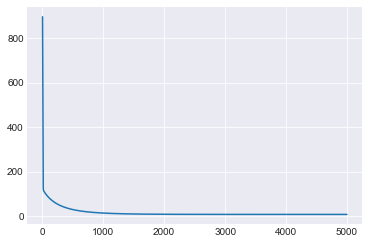

In [22]:
x = np.linspace(1,step,step)
plt.plot(x,cost)



Alternative Solution:
* Globalized Newtown-CG method as in hIPPYlib

## MCMC

In [27]:
def compute_hessian(fn, vars):
    mat = []
    for v2 in vars:
        for i in range(np.shape(vars)[0]):
            jac =[]
            with tf.GradientTape() as t2:
                for v1 in vars:
                    with tf.GradientTape() as t:
                        f = fn(vars)
                        jac.append(t.gradient(f,v1))
                hess = t2.gradient(jac[i],v2)
                if type(hess) == type(None):
                    mat.append(0)
                else:mat.append(hess.numpy())
    return np.reshape(mat,[np.shape(vars)[0],np.shape(vars)[0]])

# def f(vars):
#     return tf.pow(vars[0], cons(2)) + cons(2) * vars[0] * vars[1] + cons(3) * tf.pow(vars[1], cons(2)) + cons(4) * vars[0] + cons(5) * vars[1] + cons(6)
# print(compute_hessian(f,[x,y]))

def gravity(vars):
    G=6.67e-11
    return ((4/3)*np.pi * (vars[2]**3) * vars[1]* G 
       * vars[0]/(x**2 + vars[0]**2)**(3/2)) * 1e5 

mu = MAP

sphere_center = tf.Variable(mu[0])
density_difference = tf.Variable(mu[1])
sphere_radius = tf.Variable(mu[2])

hess = compute_hessian(gravity,[sphere_center,density_difference,sphere_radius])


In [25]:
## wrong hessian
hess

array([[ 0.00108262, -0.00032089, -0.00474383],
       [-0.00032089,  0.        ,  0.00279868],
       [-0.00474384,  0.00279868,  0.02758266]])

###  2019-11-26 correct the hessian to the Hessian of the negative log posterior rather than gravity

In [28]:
def negative_log_post(vars):
    grav = grav_analytical_tf_det(x_obs,vars, cov)
    term_1 = matrixcompute(grav,grav_obs_array_withnoise,noise_tensor)
    term_2 = matrixcompute(vars,mu_prior,cov)
    return tf.add(term_1,term_2)

hess = compute_hessian(negative_log_post,[sphere_center,density_difference,sphere_radius])


In [29]:
## New Hessian
hess

array([[ 0.10442383, -0.03223087, -0.47648168],
       [-0.03223087,  0.02170533,  0.17268007],
       [-0.4764816 ,  0.17268008,  2.564593  ]], dtype=float32)

### Forward model in TensorFlow

* Calculate Hessian
* Variable defined in Edward multivariate Normal object

In [30]:
@tf.function
def grav_analytical_tf(x, mu, cov):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G 
           * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 
    
    return gravity

grav = grav_analytical_tf(x_obs, MAP, cov)

print(grav)

tf.Tensor(
[0.0738949  0.09598228 0.12207878 0.1489518  0.17021054 0.17844512
 0.17021054 0.1489518  0.12207878 0.09598228 0.0738949 ], shape=(11,), dtype=float32)


#### Compute the Hessian and Covariance of the Posterior at MAP

\begin{equation}
\mathcal{C}_{\mathrm{post}}=\left(\mathcal{H}_{\mathrm{misfit}}\left(m_{\nu}\right)+\mathcal{C}_{\mathrm{prior}}^{-1}\right)^{-1}
\end{equation}

In [31]:
Matrix_tem = tf.add(hess, tf.linalg.inv(cov))

C_post = tf.linalg.inv(Matrix_tem)

In [32]:

print('hessian matrix at MAP: \n', hess)
print('Covariance of the Prior: \n',cov)
print('Covariance of the Posterior: \n',C_post)

hessian matrix at MAP: 
 [[ 0.10442383 -0.03223087 -0.47648168]
 [-0.03223087  0.02170533  0.17268007]
 [-0.4764816   0.17268008  2.564593  ]]
Covariance of the Prior: 
 [[100, 0.0, 0.0], [0.0, 100, 0.0], [0.0, 0.0, 100]]
Covariance of the Posterior: 
 tf.Tensor(
[[38.1136      0.51677334  7.0190506 ]
 [ 0.51679003 49.700073   -3.237782  ]
 [ 7.0190473  -3.2377853   1.9045917 ]], shape=(3, 3), dtype=float32)


#### define whether to accept or reject the new sample
\begin{equation}
\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)=\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\Gamma_{\mathrm{noise}}^{-1}}
\end{equation}

\begin{equation}
a\left(m_{\text {current }}, m_{\text {proposed }}\right) :=\min \left\{1, \exp \left(\Phi\left(m_{\text {current }}, \mathbf{d}_{\text {obs }}\right)-\Phi\left(\mathrm{m}_{\text {proposed }}, \mathbf{d}_{\text {obs }}\right)\right)\right\}
\end{equation}

### generalized-preconditioned Crank-Nicolson proposal (gpCN)

gpCN is a generalized version of the pCN sampler. While the proposals of pCN are drown from the prior Gaussian distribution $\mu_{prior}$,proposals in the generalized pCN are drown from a Gaussian approximation $v$ of the posterior distribution.

\begin{equation}
a_{\nu}\left(m_{\mathrm{current}}, m_{\mathrm{proposed}}\right) :=\min \left\{1, \exp \left(\Delta\left(m_{\mathrm{current}}\right)-\Delta\left(m_{\mathrm{proposed}}\right)\right)\right\}
\end{equation}

where   

\begin{equation}
\Delta(m)=\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\nu}\right\|_{\mathrm{C}_{\nu}^{-1}}^{2}
\end{equation}

In [33]:
def acceptance_gpCN(m_current , m_proposed):
    
    grav_current = grav_analytical_tf(x_obs,m_current, cov)
    phi_current = matrixcompute(grav_current,grav_obs_array_withnoise,noise_tensor)
    # assign a name
    phi_current = tf.identity(phi_current, name="phi_current")
    
    grav_proposed = grav_analytical_tf(x_obs,m_proposed, cov)
    phi_proposed = matrixcompute(grav_proposed,grav_obs_array_withnoise,noise_tensor)
    # assign a name
    phi_proposed = tf.identity(phi_proposed, name="phi_proposed")

    t2_current = matrixcompute(m_current,mu_prior,cov)
    t3_current = matrixcompute(m_current,MAP,C_post)

    t2_proposed = matrixcompute(m_proposed,mu_prior,cov)
    t3_proposed = matrixcompute(m_proposed,MAP,C_post)

    delta_current = tf.subtract(tf.add(phi_current,t2_current ),t3_current)
    delta_proposed = tf.subtract(tf.add(phi_proposed,t2_proposed ),t3_proposed)

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    
    ## greater : further away from the observation = less possible to accept
    then_expression = tf.greater_equal( delta_current,delta_proposed)
    else_expression = tf.greater(accept_ratio, sample,name = 'shit')
    
    condition = tf.reshape(tf.greater_equal( delta_current,delta_proposed)[0],())
    

    x = tf.cond(condition ,
               lambda: then_expression,
               lambda: else_expression)
    
    x = tf.reshape(x,())
    return x
        

#### Proposal

\begin{equation}
v^{(k)}=m_{\nu}+\sqrt{1-\beta^{2}}\left(m^{(k)}-m_{\nu}\right)+\beta \xi^{(k)}, \quad \xi^{(k)} \sim \mathcal{N}\left(0, \mathcal{C}_{\nu}\right)
\end{equation}

In [34]:
from IPython.display import clear_output
# define leaning rate
beta = 0.3

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(np.sqrt(1-beta**2),dtype = tf.float32)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= C_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed
    

    

### Chain

In [41]:
def run_chain():
    burn_in = 1000
    steps = 10000
    k = 0
    accepted = []
    rejected = []

    m_current = mu  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)
        
#         if k%20 == 0: 
#             clear_output();
#             print(k, "finised")
        
        if acceptance_gpCN(m_current,m_proposed).numpy():
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed)
        else:
            m_current = m_current
            rejected.append(m_proposed)
    
    return accepted,rejected
    print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()

In [47]:
np.shape(accepted)[0]
print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/10000))

acceptance rate = 50.7%


In [37]:
def plot_trace(accepted):
            
    sphere_center_accepted = []
    density_difference_accepted = []
    sphere_radius_accepted = []
    for i in range(np.shape(accepted)[0]):
        
        sphere_center_accepted.append(accepted[i][0])
        density_difference_accepted.append(accepted[i][1])
        sphere_radius_accepted.append(accepted[i][2])
        
        
    fig, axes = plt.subplots(1, 3, sharex='col', sharey='col')
    fig.set_size_inches(17, 4)
    
    axes[0].hist(sphere_center_accepted,40,density=True)
    axes[1].hist(density_difference_accepted,40,density=True)
    axes[2].hist(sphere_radius_accepted,40,density=True)


    ## print prior
    for i in range(3):

        axes[i].plot(xvals[i], norm_list[i],label="prior")
        axes[i].title.set_text(name_list[i])
        axes[i].axvline(truevalue_list[i], label="true value", color='k', 
                linestyle='--', linewidth=2)
        axes[i].legend();


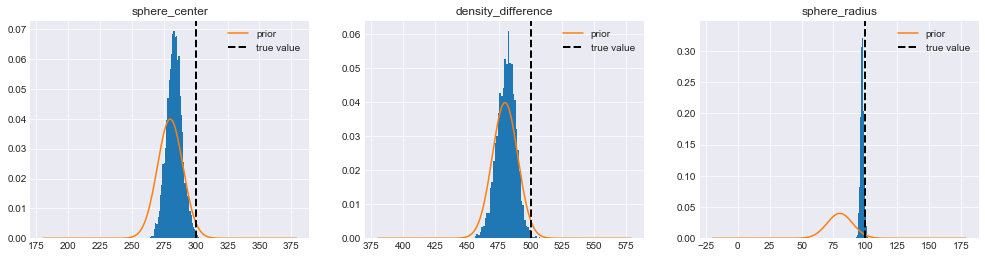

In [38]:
plot_trace(accepted)

In [39]:
import corner 

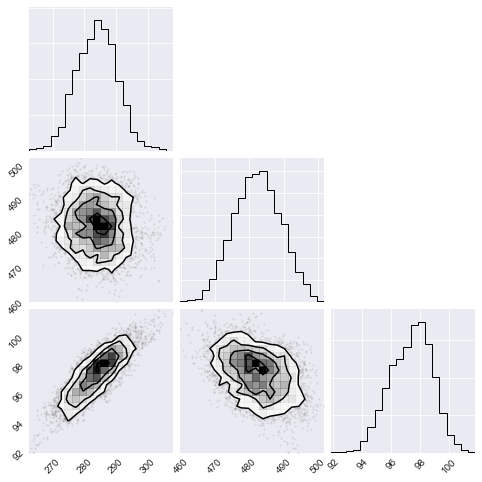

In [49]:
figure = corner.corner(accepted)
# plt.savefig('gravity_1_0')

#### Let's try to compare with random walk metropolis MCMC